In [17]:
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
print(os.listdir("../input"))

import zipfile

#캐글 환경에서 압축파일을 받아 압축을 풀어 폴더에 저장

with zipfile.ZipFile("../input/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("../input/test1.zip","r") as z:
    z.extractall(".")

['test1.zip', 'train.zip', 'sampleSubmission.csv']


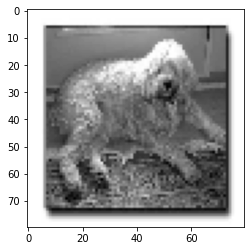

In [18]:
main_dir = "/kaggle/working/"
train_dir = "train"
path = os.path.join(main_dir,train_dir)

#이미지의 일부를 전처리하여 확인
for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    plt.imshow(new_img_array,cmap="gray")
    break


In [19]:
#X 리스트에는 이미지를 전처리하여 저장하고 y에는 강아지와 고양이를 카테고리를 분류하여 정답을 설정한다
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(category)
    

In [20]:
create_test_data(path)
X = np.array(X).reshape(-1, 80,80,1)
y = np.array(y)

In [21]:
#Normalize data
X = X/255.0

In [22]:
#earlystop을 설정하여 오버피팅이 되는 것을 방지한다
#학습하는 동안 정확도를 확인하고 있다가 어느 기준이 되면 학습율을 조정해주는 클래스입니다
earlystop=EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',
                                          patience=2,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr=0.00001)

In [23]:
#earlystop,learning_rate_reduction이 정의 된 것을 callbacks에 담아 놓습니다
callbacks=[earlystop,learning_rate_reduction]

In [24]:
#모델
model = Sequential()
model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = X.shape[1:]))
model.add(MaxPooling2D(pool_size = (2,2)))
# Add another:
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
#모델 학습
history=model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2,callbacks=callbacks)

Epoch 1/50
625/625 [==============================] - 160s 256ms/step - loss: 0.6614 - accuracy: 0.5932 - val_loss: 0.5373 - val_accuracy: 0.7258
Epoch 2/50
625/625 [==============================] - 167s 267ms/step - loss: 0.5116 - accuracy: 0.7493 - val_loss: 0.4896 - val_accuracy: 0.7624
Epoch 3/50
625/625 [==============================] - 164s 262ms/step - loss: 0.4316 - accuracy: 0.8002 - val_loss: 0.4622 - val_accuracy: 0.7824
Epoch 4/50
625/625 [==============================] - 164s 263ms/step - loss: 0.3807 - accuracy: 0.8278 - val_loss: 0.4852 - val_accuracy: 0.7824
Epoch 5/50
625/625 [==============================] - 165s 263ms/step - loss: 0.3050 - accuracy: 0.8660 - val_loss: 0.4993 - val_accuracy: 0.7894
Epoch 6/50
625/625 [==============================] - 173s 277ms/step - loss: 0.2260 - accuracy: 0.9068 - val_loss: 0.5437 - val_accuracy: 0.7850
Epoch 7/50
625/625 [==============================] - 166s 265ms/step - loss: 0.1485 - accuracy: 0.9456 - val_loss: 0.6030 -

In [26]:
#모델 저장
model.save_weights("model1.h5")

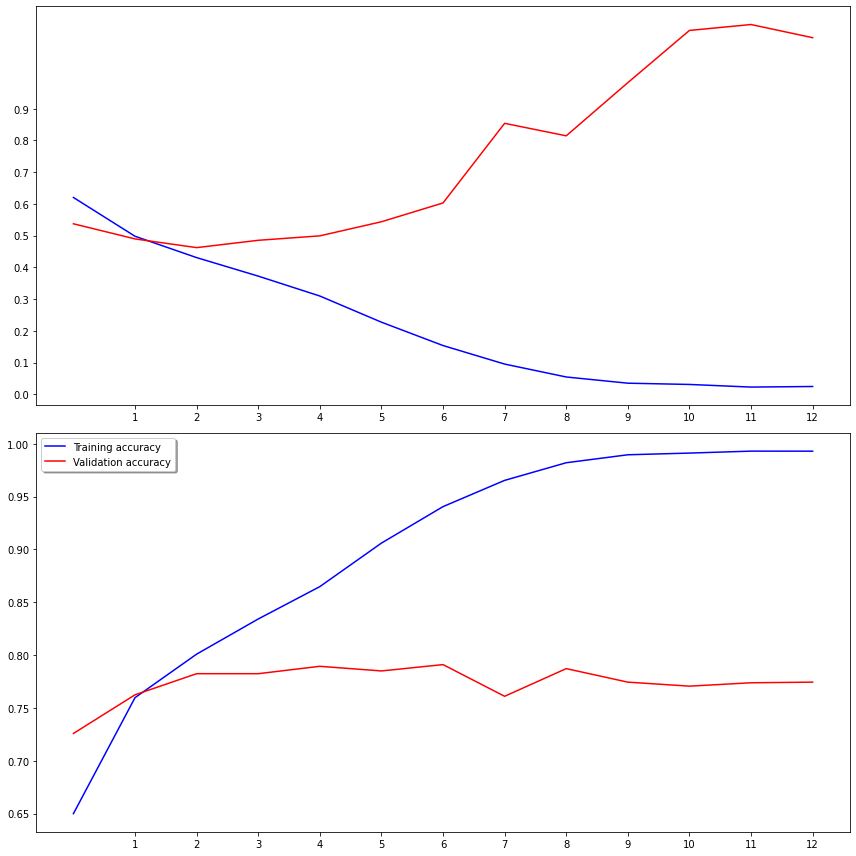

In [28]:
# 학습 내용을 그래프를 통해 확인합니다
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,12))
ax1.plot(history.history['loss'],color='b',label="Training loss")
ax1.plot(history.history['val_loss'],color='r',label="Validation loss")
ax1.set_xticks(np.arange(1,13,1))
ax1.set_yticks(np.arange(0,1,0.1))

ax2.plot(history.history['accuracy'],color='b',label="Training accuracy")
ax2.plot(history.history['val_accuracy'],color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1,13,1))

legend=plt.legend(loc='best',shadow=True)
plt.tight_layout()
plt.show()